### Author : Sayali Kudale

### Implementation of K-Means Clustering

In [1]:
# import the necessary libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold

In [2]:
# load the data
df_questionsAllData = pd.read_csv("Data/SO_ProcessedData.csv", encoding="ISO-8859-1")

In [3]:
# Split the data into questions and answers 
Df_QuestionText= df_questionsAllData[["QuestionText"]]
Df_Answers = df_questionsAllData[['Tags','CreationDate', 'AnswerOwnerUserId','AnswerCreationDate','AnswerScore']]


In [4]:
vectorizer = TfidfVectorizer(stop_words = "english")

In [5]:
# optimal number of clusters
num_clusters = 25

#### TfidVectorization : Feature engineering step which converts text data into numerical vectors
##### input : all documents in text format 
##### output: returns the numerical vectors and object of vectorizer

In [6]:
def TfidVectorization(data):
    vec = vectorizer.fit(data)   
    vectorized = vec.transform(data)
    return vec, vectorized
    

#### getTopTermsInGroup : get top n high probable terms each cluster 
##### input : K-means model
##### output:  list of list giving top n words of each topic
##### purpose:  This method selects top n words which has high weight in a topic and add in a list

In [7]:

def getTopTermsInGroup(km):
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    topTermsInGroup=[]
    terms = vectorizer.get_feature_names()
    for i in range(num_clusters):
        group=[]
        for ind in order_centroids[i, :50]:
            group.append(terms[ind])
        topTermsInGroup.append(group)
    
    return topTermsInGroup

#### rankResult : Use to rank the data in  clusters 
##### input : date of posted question, predicted cluster, Group of clusters
##### output: top 50 user as a recommended answerer to the question
##### purpose:  This method filter the records which are within the 2 months of given date and then sort the filtered data using the AnswerScore


In [8]:
# Ranking the results
def rankResult(date ,topic, allTopicData):
    topicData=allTopicData.get_group(topic)
    start_date =pd.to_datetime(date) + pd.DateOffset(months=-1)
    end_date = pd.to_datetime(date) + pd.DateOffset(months=1)
    after_start_date = pd.to_datetime(topicData["AnswerCreationDate"]) >= start_date
    before_end_date = pd.to_datetime(topicData["AnswerCreationDate"]) <= end_date
    between_two_dates = after_start_date & before_end_date
    filtered_dates = topicData.loc[between_two_dates]
    sortByScore=filtered_dates.sort_values("AnswerScore",ascending=False)
    return ','.join(str(v) for v in sortByScore["AnswerOwnerUserId"].unique()[:50])


#### tag_similarity : Use to evaluate the performance of model
##### input : two list of strings
##### output: tag similarity 
##### purpose: calculate the similarity metric using the number of list1 words found in list two divided by total number of words in list1 


In [9]:
def tag_similarity(list1, list2):
    intersection = len(set(list1).intersection(list2))
    return float(intersection) / len(list1)


#### userMatching : origional answerer matching with recommended answerer
##### input :  origional answrer id , list of recommended answerer id
##### output:  return 1 if original answerer present in the recommended anwerer list otherwise returns 0
##### purpose:  to check if origional answerer is in the list of recommended answerer

In [10]:
def userMatching(origional, predicted):
    
    if str(origional) in predicted.split(","):
        return 1
    else:
        return 0

In [11]:
# cross validation with splits as 5
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

### K-Means Clustering with 5 fold cross validation

##### Below code splits the input data into 5 folds 
##### train the k-means model with the 4 sets 
##### performs prediction on the 1 test set 
##### computes the PredictedTopic, RecommendedAnswerer, TagSim, UserSim and add columns in the Df_Answers dataframe
##### calculates the mean  of tag sim score as accuracy for each fold 
##### calculates the mean  of user sim score as userAccuracy for each fold 

In [12]:
accuracy=[]
userAccuracy=[]


for train_ix, test_ix in kfold.split(Df_QuestionText):

    train_qstns, test_qstns = Df_QuestionText.iloc[train_ix], Df_QuestionText.iloc[test_ix]
    train_ans, test_ans = Df_Answers.iloc[train_ix], Df_Answers.iloc[test_ix]
    
    vec, qstnData = TfidVectorization(train_qstns["QuestionText"].values.astype('U'))
    km = KMeans(n_clusters=num_clusters)
    km.fit(qstnData)
    train_ans["Cluster"] = km.labels_.tolist()
    TrainingGroup = train_ans.groupby(train_ans['Cluster'])
    topTermsInGroup=getTopTermsInGroup(km)
    test_vec = vec.transform(test_qstns["QuestionText"].values.astype('U'))
    test_ans["PredictedCluster"]=km.predict(test_vec)
    test_ans["RecommendedAnswerer"]= test_ans.apply(lambda x: rankResult(x.CreationDate,x.PredictedCluster,TrainingGroup),axis=1)
    test_ans["TagSim"]= test_ans.apply(lambda x: tag_similarity(x.Tags.split(),topTermsInGroup[x.PredictedCluster]),axis=1) 
    accuracy.append(test_ans["TagSim"].mean())
    test_ans["UserSim"]= test_ans.apply(lambda x: userMatching(x.AnswerOwnerUserId,x.RecommendedAnswerer),axis=1) 
    userAccuracy.append(test_ans["UserSim"].mean())

    

#### Tag similarity score for each fold 

In [13]:
accuracy

[0.40876591576885346,
 0.3952905648057447,
 0.42946763793666287,
 0.40011937557391963,
 0.4323620038771547]

#### User similarity score for each fold 


In [14]:
userAccuracy

[0.17225759059745346,
 0.1598922624877571,
 0.1657688540646425,
 0.16100397918579737,
 0.17551270278543005]

### Below code creates the dataframe of top 10 keywords of each topic

In [36]:
topKeywordsInGroup=pd.DataFrame()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    group=[]
    for ind in order_centroids[i, :10]:
        group.append(terms[ind])
    topKeywordsInGroup[i]=group

In [37]:
# visualisation of top 10 keywords in each topic
topKeywordsInGroup

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,python,list,data,button,error,number,row,function,query,column,...,file,django,array,cell,image,document,cs,class,javascript,plot
1,time,python,frame,click,message,python,column,javascript,table,dataframe,...,json,model,object,sheet,cs,mongodb,html,method,jquery,matplotlib
2,value,element,column,javascript,python,value,dataframe,return,sql,panda,...,csv,field,javascript,googlesheets,html,collection,div,instance,page,ggplot2
3,change,value,panda,html,function,count,panda,argument,mysql,value,...,python,view,value,vba,background,field,element,java,html,bar
4,result,item,value,radio,file,digit,value,value,result,python,...,directory,python,element,column,javascript,query,text,function,element,data
5,method,dictionary,dataframe,jquery,property,column,data,parameter,column,row,...,folder,user,index,excel,display,aggregationframework,javascript,constructor,click,graph
6,user,column,row,change,type,function,python,python,record,data,...,text,djangomodels,result,value,size,mongodbquery,box,object,tag,color
7,function,index,python,page,javascript,string,group,error,data,group,...,script,post,function,formula,docker,mongoose,color,cplusplus,form,label
8,javascript,string,time,function,flutter,javascript,number,pas,join,index,...,error,error,data,google,file,array,container,property,div,point
9,java,data,json,cs,command,time,result,time,value,result,...,line,form,item,row,page,aggregation,flexbox,type,value,python


### WordCloud representation of the topic 2
#### This wordcloud representation depicts topic python, pandas, dataframe

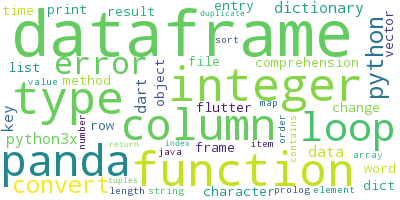

In [17]:

# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ' ,'.join(topTermsInGroup[1:2][0])

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### WordCloud representation of the topic 8
#### This wordcloud representation depicts topic as C++

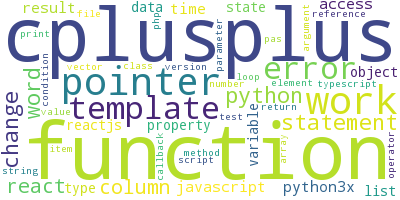

In [23]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ' ,'.join(topTermsInGroup[7:8][0])

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### WordCloud representation of the topic 9
#### This wordcloud representation depicts topic as SQL

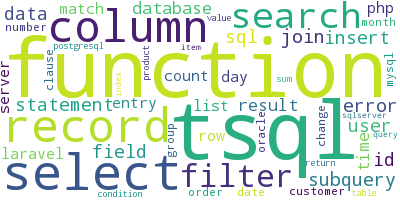

In [24]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ' ,'.join(topTermsInGroup[8:9][0])

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### visualise the test data in cluster of topic 8


In [40]:
test_ans[test_ans["PredictedCluster"]==8]

,Tags,CreationDate,AnswerOwnerUserId,AnswerCreationDate,AnswerScore,PredictedCluster,RecommendedAnswerer,TagSim,UserSim
7,mysql sql,2020-01-01 03:00:02,3652345,2020-01-01 03:05:47,1,8,"11032757,807126,185647,6766457,1144035,5841306...",1.000000,0
18,mysql,2020-01-01 04:06:19,3470178,2020-01-01 05:03:57,1,8,"11032757,807126,185647,6766457,1144035,5841306...",1.000000,0
97,mysql,2020-01-02 07:44:57,2131212,2020-01-02 08:07:43,0,8,"11032757,807126,185647,1863229,6828706,1144035...",1.000000,0
318,mysql,2020-01-03 12:53:46,3627756,2020-01-03 13:50:14,1,8,"11032757,807126,185647,1144035,6766457,8562480...",1.000000,0
763,python pandas dataframe,2020-01-08 04:13:15,10193760,2020-01-08 06:46:19,3,8,"11032757,11644308,185647,807126,1570000,608228...",0.000000,0
839,mysql,2020-01-07 16:16:12,20860,2020-01-07 16:41:15,4,8,"11032757,11644308,185647,807126,6082280,157000...",1.000000,0
845,sql sql-server,2020-01-08 03:28:27,1144035,2020-01-08 13:02:20,1,8,"11032757,11644308,185647,807126,1570000,608228...",0.500000,1
889,sql google-bigquery,2020-01-08 16:42:17,1144035,2020-01-08 18:06:38,4,8,"11032757,11644308,185647,1570000,807126,608228...",0.500000,1
890,sql sql-server,2020-01-08 16:01:02,9071943,2020-01-08 16:14:14,1,8,"11032757,11644308,185647,1570000,807126,608228...",0.500000,1
1014,mysql sql,2020-01-09 15:32:46,97513,2020-01-09 15:41:53,2,8,"11032757,11644308,185647,807126,6082280,157000...",1.000000,0


#### check the skills of recommended users of one of the test set question  by retriving the previous answers given in traning data set

In [45]:
# 11032757,807126,185647,6766457,1144035,5841306

train_ans[train_ans["AnswerOwnerUserId"]==5841306]

,Tags,CreationDate,AnswerOwnerUserId,AnswerCreationDate,AnswerScore,Cluster
1917,sql oracle,2020-01-14 16:43:37,5841306,2020-01-14 16:51:02,4,8
9187,sql oracle,2020-03-07 07:29:35,5841306,2020-03-07 07:51:26,0,8
9598,sql sql-server,2020-03-13 17:16:20,5841306,2020-03-13 17:45:38,1,8
12552,sql oracle,2020-03-30 15:01:06,5841306,2020-03-30 15:59:20,1,13
17374,oracle plsql,2020-04-28 08:19:02,5841306,2020-04-28 08:49:31,1,4
21271,mysql sql,2020-05-22 07:51:48,5841306,2020-05-22 08:07:30,1,8
26855,sql presto,2020-06-15 22:18:08,5841306,2020-06-16 13:35:00,1,13
35330,sql oracle plsql,2020-08-06 18:18:29,5841306,2020-08-06 18:37:58,2,4
36093,sql oracle,2020-08-14 14:26:13,5841306,2020-08-14 14:37:46,1,6
37440,python tkinter,2020-09-02 22:33:24,5841306,2020-09-02 22:56:10,1,12
